In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sys.path += ["../src"]
import causal_model
from matplotlib.pyplot import subplots as sbp
from importlib import reload
from glob import glob
import climact_utils as cu

In [3]:
path_to_data = "/data/shared/xxx/climact/experiments/"

### Utils

In [5]:
df = causal_model.load_dataframe("activism")


In [96]:
def weighted_avg_cols(df, col1, col2, w1, w2):
    
    return (df[col1] * w1 + df[col2] * w2) / (w1 + w2)

def subreddits_union(df, col1, col2):
    return df[col1]|df[col2]

def create_df_merge_longmedium(df):
    subreddit_list = [u for u in sorted(cu.subreddits) if (f"r{u}_long" in df.columns)&(f"r{u}_medium" in df.columns)&(f"r{u}_short" in df.columns)]
    df_longmedium = pd.concat([
    df[cu.features_join["interaction_short"] + cu.features_join["norm_news_short"] + cu.features_join["control_short"] + [f"r{u}_short" for u in subreddit_list]],
    pd.DataFrame([weighted_avg_cols(df, u + "_medium", u + "_long", 4, 47) for u in (cu.features["norm_news"] + cu.features["control"])],
                 index = cu.features_join["norm_news_long"] + cu.features_join["control_long"]).T,
    pd.DataFrame([subreddits_union(df, f"r{u}_medium", f"r{u}_long") for u in subreddit_list], index = [f"r{u}_long" for u in subreddit_list]).T
                 ], axis = 1).assign(activation = df["activation"])
    return df_longmedium

def create_df_merge_shortmedium(df):
    subreddit_list = [u for u in sorted(cu.subreddits) if (f"r{u}_long" in df.columns)&(f"r{u}_medium" in df.columns)&(f"r{u}_short" in df.columns)]
    df_shortmedium = pd.concat([
    df[cu.features_join["interaction_long"] + cu.features_join["norm_news_long"] + cu.features_join["control_long"] + [f"r{u}_long" for u in subreddit_list]],
    pd.DataFrame([weighted_avg_cols(df, u + "_medium", u + "_short", 4, 1) for u in (cu.features["interaction"] + cu.features["norm_news"] + cu.features["control"])],
                 index = cu.features_join["interaction_short"] + cu.features_join["norm_news_short"] + cu.features_join["control_short"]).T,
    pd.DataFrame([subreddits_union(df, f"r{u}_medium", f"r{u}_short") for u in subreddit_list], index = [f"r{u}_short" for u in subreddit_list]).T
                 ], axis = 1).assign(activation = df["activation"])
    df_shortmedium[cu.features_join["interaction_short"]] = df_shortmedium[cu.features_join["interaction_short"]] > 0
    return df_shortmedium




In [97]:
model_settings = {
    "lr": 0.01,
    "n_epochs": 200,
    "subreddit_class": "activism",
    "var_opinions": 0.1
                  }

In [98]:
subreddit_list = [u for u in sorted(cu.subreddits) if (f"r{u}_long" in df.columns)&(f"r{u}_medium" in df.columns)&(f"r{u}_short" in df.columns)]

In [99]:
data, data_obs = causal_model.get_data(create_df_merge_shortmedium(df), causal_model.scores)
subreddit_list = data[-1]
init_params_normal, init_params_multivariatenormal = causal_model.get_init_params(len(df))
init_params = causal_model.initialize_params(init_params_normal, init_params_multivariatenormal)
guide, svi = causal_model.get_guide(causal_model.model, model_settings, data, data_obs,
                                    init_params_normal, init_params_multivariatenormal, multivariate = True)


100%|██████████| 200/200 [00:40<00:00,  4.93it/s, init loss: 4776011.0000, avg. loss [191-200]: 1724462.7500]


1727013.9


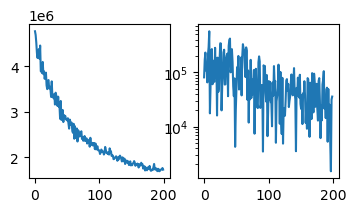

In [100]:
guide, svi_results, betas = causal_model.train(svi, guide, data, data_obs, model_settings,
                                               init_params_normal, init_params_multivariatenormal,
                                                 progress_bar = True, path = None, print_loss = True)

In [80]:
betas

{'beta_to_opinions': age                                          0.0
 gender                                       0.0
 partisan                              -0.6449502
 affluence                             -0.4215549
 avg_comments_per_thread_long                 0.0
 n_submissions_author_week_long               0.0
 n_active_days_author_week_long               0.0
 n_comments_author_week_long                  0.0
 n_different_subreddits_long                  0.0
 log_avg_comments_per_thread_long             0.0
 log_n_submissions_author_week_long           0.0
 log_n_active_days_author_week_long           0.0
 log_n_comments_author_week_long              0.0
 log_n_different_subreddits_long              0.0
 norm_climate_long                            0.0
 norm_climate_action_long                     0.0
 norm_natural_disaster_long                   0.0
 intercept                                    0.0
 dtype: object,
 'beta_to_activity_ST': avg_comments_per_thread_long            

### Robustness Analysis

In [4]:
for u in range(10,20):
    files = sorted(glob(causal_model.path_to_exp + f"*_robustness_241009*k{u}*"))
    pickles = [causal_model.read_pkl(file) for file in files]
    df_robustness = pd.DataFrame([causal_model.get_experiments_data(pickle, other_vars_settings = ["merge"]) for pickle in pickles])
    df_robustness.to_csv(causal_model.path_to_exp + f"activism_robustness_exp_241009_k{u}.csv")
    print("save_csv", u)

save_csv 10
save_csv 11
save_csv 12
save_csv 13
save_csv 14
save_csv 15
save_csv 16
save_csv 17
save_csv 18
save_csv 19


In [4]:
df_robustness = pd.concat([pd.read_csv(causal_model.path_to_exp + f"activism_robustness_exp_241009_k{u}.csv", index_col = 0) for u in range(10, 20)])

In [5]:
df = df_robustness.sort_values("accuracy_mean", ascending = False).groupby(["merge", "var_opinions"]).first().reset_index()

In [9]:
mypalette = sns.color_palette("colorblind")

In [10]:
mypalette[0] = mypalette[6]
mypalette[1] = mypalette[8]
mypalette[2] = mypalette[9]

In [10]:
# selected_var_opinion = ["1e-09", "0.001", "0.01", "0.1", "1.0", "10.0", "100.0", "1000.0", "10000000.0"]
selected_var_opinion = ["0.01", "1.0", "100.0"]
# selected_var_opinion = ["0.001", "0.1", "10.0", "1000.0"]
selected_var_opinion = [float(u) for u in selected_var_opinion]

In [7]:
mypalette = mypalette = [sns.color_palette("YlGn", n_colors = 20)[u] for u in [6,11,16]]

In [8]:
condition = "var_opinions in @selected_var_opinion"

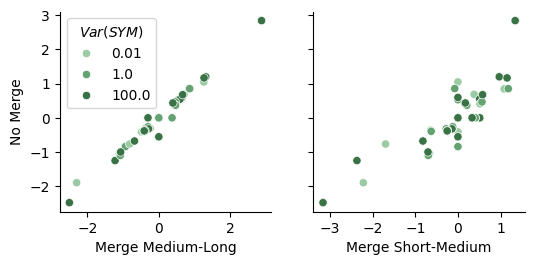

In [94]:
fig, axes = sbp(ncols = 2, figsize = (6, 2.6), sharey = True)
# fig.tight_layout()

for j, x in enumerate(["longmedium", "shortmedium"]):
    sns.scatterplot(data = df.query(condition).set_index(["merge", "var_opinions"]).iloc[:,9:].unstack().T.reset_index().assign(var_opinions = lambda x: x["var_opinions"].astype(str)),
                    x = x, y = "no_merge", hue = "var_opinions", ax = axes[j], palette = mypalette)
    axes[j].legend(title = "$Var(SYM)$").set_visible(j == 0)
    axes[j].set_ylabel("No Merge")
    axes[j].set_xlabel(["Merge Medium-Long", "Merge Short-Medium"][j])
    axes[j].spines['top'].set_visible(False)
    axes[j].spines['right'].set_visible(False)



fig.show()
fig.savefig(f"../paper/robustness_scatterplot.pdf", format = "pdf", bbox_inches = "tight")


In [15]:
df.query(condition).set_index(["merge", "var_opinions"]).iloc[:,9:].unstack().T.reset_index().assign(var_opinions = lambda x: x["var_opinions"].astype(str))[["longmedium", "no_merge", "shortmedium"]].corr()

merge,longmedium,no_merge,shortmedium
merge,,,
longmedium,1.000000,0.997077,0.818174
no_merge,0.997077,1.000000,0.806448
shortmedium,0.818174,0.806448,1.000000


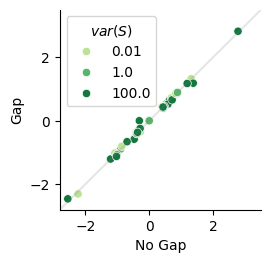

In [13]:
fig, axes = sbp(ncols = 1, figsize = (2.6, 2.6))
# fig.tight_layout()

lim0, lim1 = -2.8, 3.5
sns.lineplot(x = (lim0, lim1), y = (lim0, lim1), color = "grey", alpha = 0.2)

sns.scatterplot(data = df.query(condition).set_index(["merge", "var_opinions"]).iloc[:,9:].unstack().T.reset_index().assign(var_opinions = lambda x: x["var_opinions"].astype(str)),
                x = "longmedium", y = "no_merge", hue = "var_opinions", palette = mypalette)
axes.legend(title = "$var(S)$")#.set_visible(j == 0)
axes.set_ylabel("Gap")
axes.set_xlabel("No Gap")

axes.set_ylim((lim0, lim1))
axes.set_xlim((lim0, lim1))


axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

axes.set_xticks([-2,0,2])
axes.set_yticks([-2,0,2])

fig.show()
fig.savefig(f"../paper/robustness_scatterplot.pdf", format = "pdf", bbox_inches = "tight")
